In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime
import pytz
import os

In [2]:
def new_fig(figsize=(8.9, 5)):
    plt.close()
    fig = plt.figure(figsize=figsize)
    ax1 = fig.add_subplot(111)
    for axis in ['top','bottom','left','right']:
        ax1.spines[axis].set_linewidth(3)    
    ax1.yaxis.grid(linestyle='--')
    for tick in ax1.xaxis.get_major_ticks():
        tick.label.set_fontsize(18) 
    for tick in ax1.yaxis.get_major_ticks():
        tick.label.set_fontsize(18) 
    for line in ax1.get_xticklines() + ax1.get_yticklines():
        line.set_markersize(8)
    return ax1

# globus-url-copy

### Read

In [25]:
def read_parse_plot(ccMax, path):
    totalSize = 2**40
    #ccList = range(2, ccMax + 2, 2)
    tr = []
    timeElapsed = []
    timeStamps = []
    with open(path, 'r') as fp:
        for cc in ccList:
                timestamp = fp.readline().rstrip('\n')
                timeStamps.append(timestamp)
                fp.readline().rstrip('\n')
                timestr = fp.readline().rstrip('\n')
                #print(timestr)
                try:
                        time = float(timestr)
                except:
                        break
                timeElapsed.append(time)
                speed = totalSize / time
                speed = float("%.2f" % (speed / (2**30)))
                tr.append(speed)
                timestamp = fp.readline().rstrip('\n')
                #print("cc=" + str(cc) + ":      " + "transfer rate=" + str(speed) + "GB/s")
    #print(tr[])
    ax = new_fig(figsize = (12, 5))
    print(len(ccList), len(tr))
    np.save("data/read_speed.npy", tr)
    np.save("data/ccList.npy", ccList)
    plt.bar(ccList, tr)
    plt.xlabel("Concurrency", fontsize=20)
    plt.ylabel("Throughput(GB/s)", fontsize=20)
    ax = plt.gca()
    ax.yaxis.grid(linestyle = "--")
    plt.savefig("fig/lustre_read.pdf", bbox_inches="tight")
    plt.show()
    trMax = max(tr)
    trMaxIdx = tr.index(trMax)
    print("Highest transfer rate achieved is " + str(max(tr)) + "GB/s, when cc is " + str(ccList[trMaxIdx]))

17 17


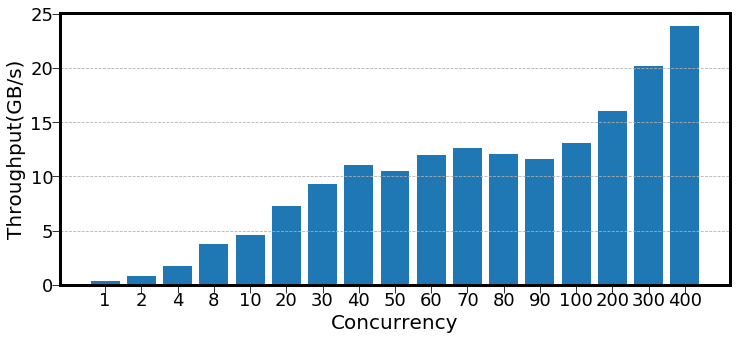

Highest transfer rate achieved is 23.89GB/s, when cc is 400


In [26]:
ccList = [1, 2, 4, 8, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300, 400]
ccList = [str(cc) for cc in ccList]
path = "/global/cscratch1/sd/yuanlai/gf_test/read_test_results/vary_cc_result/08.31-15.49.43.txt"
read_parse_plot(ccList, path)

### Write

In [27]:
def lustre_write_parse_plot(ccList, path):
    time = 60
    #ccList = range(2, ccMax + 2, 2)
    tr = []
    timeStamps = []
    with open(path, 'r') as fp:
            for cc in ccList:
                    timestamp = fp.readline().rstrip('\n')
                    timeStamps.append(timestamp)
                    cc = fp.readline().rstrip('\n')
                    sizestr = fp.readline().rstrip('\n')
                    #print timestr
                    size = sizestr.split("\t")[0]
                    #print(size)
                    unit = size[-1]
                    size = size[:-1]

                    size = float(size) * (1000 if unit == "T" else 1) 
                    speed = size / time
                    speed = float("%.2f" % speed)
                    tr.append(speed)
                    timestamp = fp.readline().rstrip('\n')
                    timeStamps.append(timestamp)
                    #print("cc=" + str(cc) + ":      " + "write speed=" + str(speed) + "GB/s")
    #matplotlib.rc('text', usetex = True)
    new_fig(figsize = (12, 5))
    np.save("data/write_speed.npy", tr)
    plt.bar(ccList, tr)
    plt.xlabel("Concurrency", fontsize=20)
    plt.ylabel("Throughput(GB/s)", fontsize=20)
    #plt.title('Lustre write performace test using globus-url-copy')
    #ax = plt.axes()
    ax = plt.gca()
    ax.yaxis.grid(linestyle='--')
    plt.savefig("fig/lustre_write.pdf", bbox_inches="tight")
    plt.show()
    trMax = max(tr)
    trMaxIdx = tr.index(trMax)
    print("Highest write speed achieved is " + str(max(tr)) + "GB/s, when cc is " + str(ccList[trMaxIdx]))

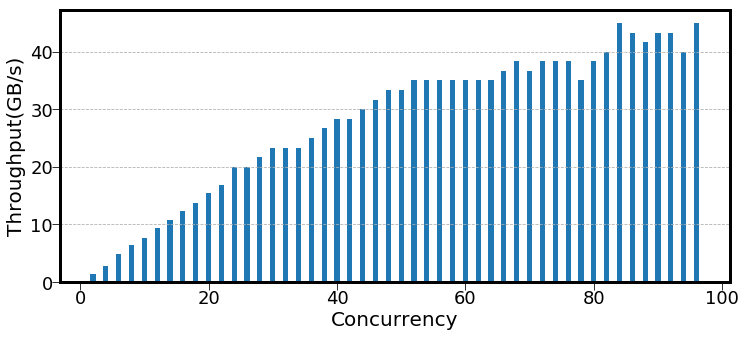

Highest write speed achieved is 45.0GB/s, when cc is 84


In [7]:
ccList = range(2, 96 + 2, 2)
path = "/global/cscratch1/sd/yuanlai/gf_test/write_test_files/08.31-11.29.56_posix.txt"
lustre_write_parse_plot(ccList, path)

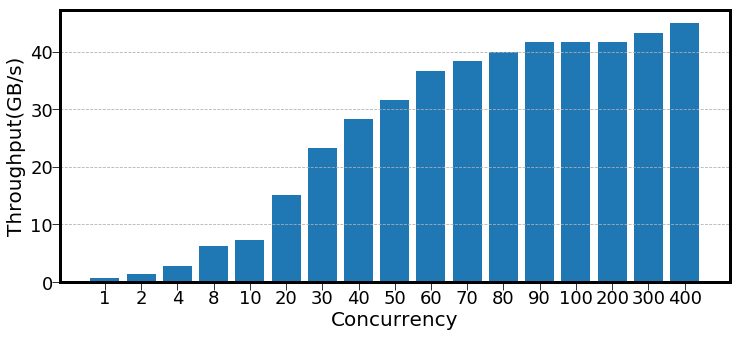

Highest write speed achieved is 45.0GB/s, when cc is 400


In [28]:
ccList = [1, 2, 4, 8, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300, 400]
ccList = [str(cc) for cc in ccList]
path = "/global/cscratch1/sd/yuanlai/gf_test/write_test_files/08.31-15.24.15.txt"
lustre_write_parse_plot(ccList, path)

# Iperf 

In [9]:
import requests 
import json
import numpy as np
import matplotlib.pyplot as plt
import time
import datetime
import matplotlib.dates as mdates

In [10]:
def get_throughput(node, port, ts=None, te=None):
    out_url = "http://graphite.es.net/snmp/west/%s/interface/%s/out?begin=%d&end=%d&calc=30"% (node, port, ts, te)
    in_url  = "http://graphite.es.net/snmp/west/%s/interface/%s/in?begin=%d&end=%d&calc=30" % (node, port, ts, te)
    r = requests.get(out_url).text
    try:
        res_out = json.loads(r)
    except:
        print(r)
    
    r = requests.get(in_url).text
    res_in = json.loads(r)

    return {'out': np.array(res_out['data']), 'in': np.array(res_in['data'])}


   # verified
alcf2nersc_esnet = (('star-cr5', 'to_anl_hpc_ip-a_v4v6'), ('chic-cr5', 'to_star-cr5_ip-a'), \
                    ('chic-cr5', 'to_star-cr5_ip-b'), ('kans-cr5', 'to_chic-cr5_ip-a'), \
                    ('denv-cr5', 'to_kans-cr5_ip-a'), ('sacr-cr5', 'to_denv-cr5_ip-a'), \
                    ('sunn-cr5', 'to_sacr-cr5_ip-a'), ('sunn-cr5', 'to_nersc_ip-a'))

nersc2alcf_esnet = (('sunn-cr5', 'to_nersc_ip-a'),    ('sacr-cr5', 'to_sunn-cr5_ip-a'),\
                    ('denv-cr5', 'to_sacr-cr5_ip-a'), ('kans-cr5', 'to_denv-cr5_ip-a'),\
                    ('chic-cr5', 'to_kans-cr5_ip-a'), ('star-cr5', 'to_chic-cr5_ip-a'), \
                    ('star-cr5', 'to_chic-cr5_ip-b'), ('star-cr5', 'to_anl_hpc_ip-a_v4v6'))

# nersc2alcf_esnet = (('denv-cr5', 'to_sacr-cr5_ip-a'), ('kans-cr5', 'to_denv-cr5_ip-a'),\
#                     ('chic-cr5', 'to_kans-cr5_ip-a'), ('star-cr5', 'to_chic-cr5_ip-a'), \
#                     ('star-cr5', 'to_chic-cr5_ip-b'), ('star-cr5', 'to_anl_hpc_ip-a_v4v6'))

# verified new path via ELPA
# alcf2nersc_esnet = (('star-cr5', 'to_anl_hpc_ip-a_v4v6'), ('star-cr5', 'to_chic-cr5_ip-a'), \
#                     ('star-cr5', 'to_chic-cr5_ip-b'), ('chic-cr5', 'to_kans-cr5_ip-a'), \
#                     ('kans-cr5', 'to_denv-cr5_ip-a'), \
#                     ('denv-cr5', 'to_albq-cr5_ip-a'), ('albq-cr5', 'to_elpa-cr5_ip-a'), \
#                     ('elpa-cr5', 'to_sunn-cr5_ip-a'), ('sunn-cr5', 'to_nersc_ip-a'))

In [11]:
def get_path_throughput(path, ts, te):
    _ret = {}
    for node, port in path:
        time.sleep(1)
        _thro = get_throughput(node, port, ts, te)
        _ret[(node, port)] = _thro
    return _ret

In [19]:
def parse_result_plot(timeStamp, period = 300):
    
    times = [timeStamp + p * 30 for p in range(period//30+2)]
    time_x = [datetime.datetime.utcfromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S') for ts in times]
    print(time_x)
    time_X = [datetime.datetime.strptime(t, '%Y-%m-%d %H:%M:%S') for t in time_x]
    dates = mdates.date2num(time_X)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d %H:%M:%S"))
    
    _res = get_path_throughput(nersc2alcf_esnet, timeStamp, timeStamp + period)
    print (len(dates)) 
    plt.close()
    new_fig(figsize=(12,5))
    for _node in _res:
        node, port = _node
        #legend.append(node + ": " + port)
        #s_port = 'to_nersc_ip-a'
        s_port = 'to_anl_hpc_ip-a_v4v6'
        if port == s_port:
            _out = _res[_node]['out'][:, 1]
            out_thro = _out * 8 / (10**9)
            plt.plot(out_thro, '--', label = node + ": " + port)
            continue
        #print(node)
        print(_node)
        _in = _res[_node]['in'][:, 1]
        #except:
         #   continue
        in_thro = _in * 8 / (10**9)
        plt.plot(in_thro, '--', label = node + ": " + port)
    plt.xticks(range(0, 22, 2), np.array(time_x)[0:22:2])
    plt.legend()
    ax = plt.gca()
    ax.yaxis.grid(linestyle = "--")
    plt.gcf().autofmt_xdate()
    plt.ylabel("Throughput(Gb/s)", fontsize=20)
    plt.savefig("fig/snmp_zero2null.pdf", bbox_inches="tight")
    plt.show()

['2018-07-20 18:43:02', '2018-07-20 18:43:32', '2018-07-20 18:44:02', '2018-07-20 18:44:32', '2018-07-20 18:45:02', '2018-07-20 18:45:32', '2018-07-20 18:46:02', '2018-07-20 18:46:32', '2018-07-20 18:47:02', '2018-07-20 18:47:32', '2018-07-20 18:48:02', '2018-07-20 18:48:32', '2018-07-20 18:49:02', '2018-07-20 18:49:32', '2018-07-20 18:50:02', '2018-07-20 18:50:32', '2018-07-20 18:51:02', '2018-07-20 18:51:32', '2018-07-20 18:52:02', '2018-07-20 18:52:32', '2018-07-20 18:53:02', '2018-07-20 18:53:32']
22
('sunn-cr5', 'to_nersc_ip-a')
('sacr-cr5', 'to_sunn-cr5_ip-a')
('denv-cr5', 'to_sacr-cr5_ip-a')
('kans-cr5', 'to_denv-cr5_ip-a')
('chic-cr5', 'to_kans-cr5_ip-a')
('star-cr5', 'to_chic-cr5_ip-a')
('star-cr5', 'to_chic-cr5_ip-b')


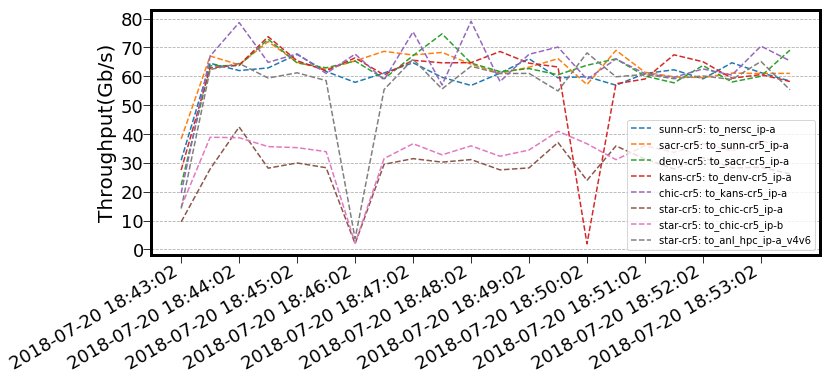

In [20]:
timeStamp = 1532112782 - 600
cc = 96
parse_result_plot(timeStamp, period = 600)
# globus transfer nersc zero to alcf null
# speed = 6.34 GB/s

['2018-09-01 05:16:03', '2018-09-01 05:16:33', '2018-09-01 05:17:03', '2018-09-01 05:17:33', '2018-09-01 05:18:03', '2018-09-01 05:18:33', '2018-09-01 05:19:03', '2018-09-01 05:19:33', '2018-09-01 05:20:03', '2018-09-01 05:20:33', '2018-09-01 05:21:03', '2018-09-01 05:21:33', '2018-09-01 05:22:03', '2018-09-01 05:22:33', '2018-09-01 05:23:03', '2018-09-01 05:23:33', '2018-09-01 05:24:03', '2018-09-01 05:24:33', '2018-09-01 05:25:03', '2018-09-01 05:25:33', '2018-09-01 05:26:03', '2018-09-01 05:26:33']
22
('sunn-cr5', 'to_nersc_ip-a')
('sacr-cr5', 'to_sunn-cr5_ip-a')
('denv-cr5', 'to_sacr-cr5_ip-a')
('kans-cr5', 'to_denv-cr5_ip-a')
('chic-cr5', 'to_kans-cr5_ip-a')
('star-cr5', 'to_chic-cr5_ip-a')
('star-cr5', 'to_chic-cr5_ip-b')


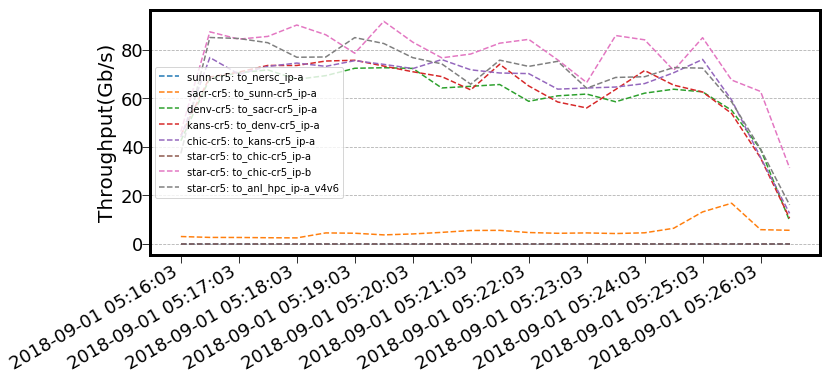

In [14]:
startStamp = 1535778963
period = 600
parse_result_plot(startStamp, period)

['2018-09-01 05:16:03', '2018-09-01 05:16:33', '2018-09-01 05:17:03', '2018-09-01 05:17:33', '2018-09-01 05:18:03', '2018-09-01 05:18:33', '2018-09-01 05:19:03', '2018-09-01 05:19:33', '2018-09-01 05:20:03', '2018-09-01 05:20:33', '2018-09-01 05:21:03', '2018-09-01 05:21:33', '2018-09-01 05:22:03', '2018-09-01 05:22:33', '2018-09-01 05:23:03', '2018-09-01 05:23:33', '2018-09-01 05:24:03', '2018-09-01 05:24:33', '2018-09-01 05:25:03', '2018-09-01 05:25:33', '2018-09-01 05:26:03', '2018-09-01 05:26:33']
22
('denv-cr5', 'to_sacr-cr5_ip-a')
('kans-cr5', 'to_denv-cr5_ip-a')
('chic-cr5', 'to_kans-cr5_ip-a')
('star-cr5', 'to_chic-cr5_ip-a')
('star-cr5', 'to_chic-cr5_ip-b')


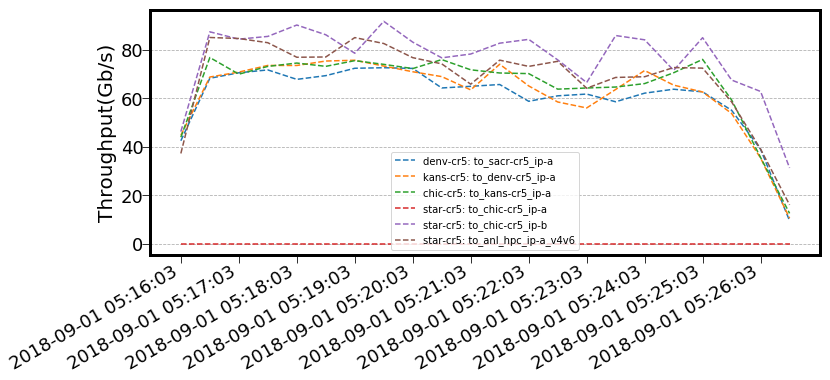

In [100]:
startStamp = 1535778963
period = 600
parse_result_plot(startStamp, period)

In [ ]:
(pd.to_datetime('2018-09-02T22:01:40.000Z') - pd.datetime.utcfromtimestamp(0)).total_seconds().__int__()

# Data distribution

In [15]:
import math

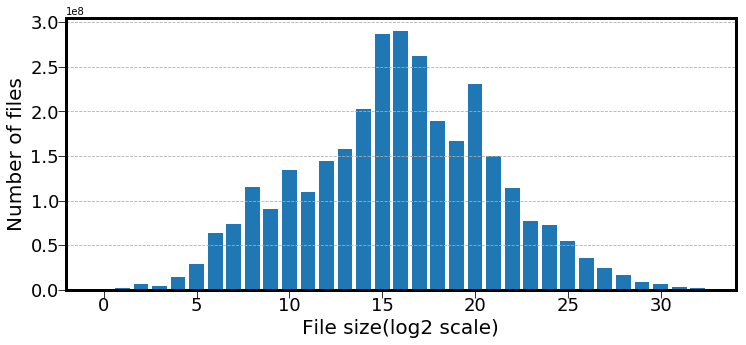

In [16]:
data = np.load('/global/cscratch1/sd/yuanlai/gf_test/byte_by_app_src-2017.npy', encoding='bytes')[()]
data = data['globusonline-fxp'][:33]
data  = list(data)
x = [i for i in range(0, 33)]
plt.close()
new_fig(figsize=(12, 5))
plt.bar(x, data)
plt.ylabel("Number of files", fontsize=20)
plt.xlabel("File size(log2 scale)", fontsize=20)
plt.show()
data_sum = sum(data)
data_accu = [0] * 33
data_accu[0] = data[0]
for i in range(1, len(data)):
    data_accu[i] = data_accu[i-1] + data[i]
data_accu = [i * 100 / data_sum for i in data_accu]

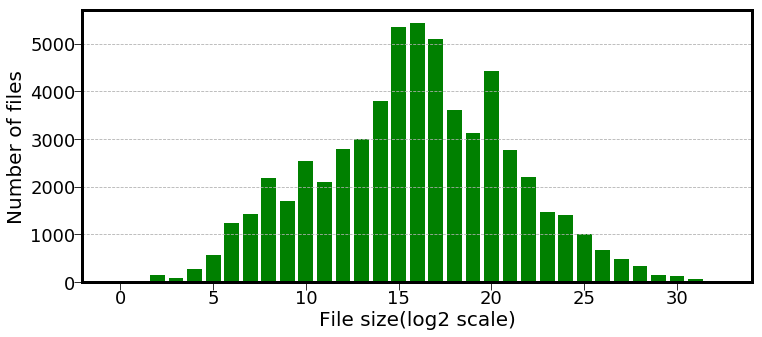

In [29]:
file = "/global/cscratch1/sd/yuanlai/gf_test/new_test_files_limit_ost_smaller/file_size"
x = [i for i in range(0, 33)]
bin_size = [0] * 33
with open(file, "r") as f:
    for line in f:
        lineSplit = line.split()
        size = int(lineSplit[4])
        if size == 0:
            break
        bin_size[int(math.log(size, 2))] += 1
bin_size_sum = sum(bin_size)
bin_size_accu = [0] * 33
bin_size_accu[0] = bin_size[0]
for i in range(1, len(bin_size)):
    bin_size_accu[i] = bin_size_accu[i-1] + bin_size[i]
bin_size_accu = [i * 100 / bin_size_sum for i in bin_size_accu]

#plt.close()
new_fig(figsize=(12, 5))
plt.bar(x, bin_size, color='g')
plt.ylabel("Number of files", fontsize=20)
plt.xlabel("File size(log2 scale)", fontsize=20)
plt.savefig("fig/data_dist.pdf", bbox_inches="tight")
np.savez("data/data_dist.npz", name1=x, name2=bin_size)
plt.show()

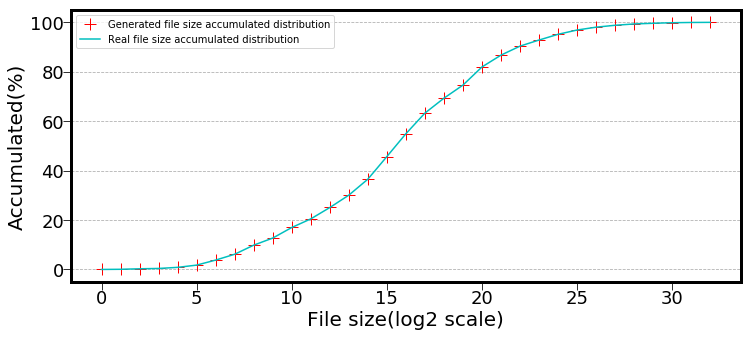

In [34]:
plt.close()
new_fig(figsize=(12, 5))
plt.plot(x, bin_size_accu, 'r+', markersize=12, label="Generated file size accumulated distribution")
plt.plot(x, data_accu, 'c-', label="Real file size accumulated distribution")
plt.legend()
plt.ylabel("Accumulated(%)", fontsize=20)
plt.xlabel("File size(log2 scale)", fontsize=20)
plt.savefig("fig/data_accu_dist.pdf", bbox_inches="tight")
np.savez("data/data_accu_dist.npz", name1=x, name2=bin_size_accu, name3=data_accu)
plt.show()